$\textbf{PROGRAMMING ASSIGNMENT}$
---
1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes.

In [53]:
import numpy as np
from sklearn.naive_bayes import logsumexp

class StochasticBernoulliMixture:
    def __init__(self, n_components, max_iter, batch_size, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.rng = np.random.default_rng(self.random_state) if self.random_state else np.random.default_rng()
        
        # Initialize old parameters
        self.old_mu = None
        self.old_pi = None
        self.old_gamma = None
    
    def fit(self, x_binary):
        self.x = x_binary
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            # Stochastic E-step and M-step
            for _ in range(self.batch_size):
                batch_indices = self.rng.choice(len(self.x), size=self.batch_size, replace=False)
                x_batch = self.x[batch_indices]
                log_bernoullis_batch = self.get_log_bernoullis(x_batch)
                self.gamma = self.get_responsibilities(log_bernoullis_batch)
                self.get_Neff()
                self.get_mu(x_batch)
                self.get_pi()
            # Compute new log_likelihood:
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break

    def reset_params(self):
        if self.old_mu is not None:
            self.mu = self.old_mu.copy()
        if self.old_pi is not None:
            self.pi = self.old_pi.copy()
        if self.old_gamma is not None:
            self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = self.rng.uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self, x_batch):
        self.mu = np.einsum('ik,ij -> kj', self.gamma, x_batch) / self.Neff[:,None]

        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

In [54]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
soybean_large = fetch_ucirepo(id=90) 
  
# data (as pandas dataframes) 
X = soybean_large.data.features 
y = soybean_large.data.targets 

In [55]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Preprocessing
# Handling missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# One-hot encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_imputed).toarray()  # Convert to dense array

# Perform clustering
n_components = 3  # Number of clusters
max_iter = 100  # Maximum number of iterations
batch_size = 50  # Size of mini-batch

# Initialize the StochasticBernoulliMixture model
stochastic_bmm = StochasticBernoulliMixture(n_components=n_components, max_iter=max_iter, batch_size=batch_size)

# Fit the model to the binary encoded data
stochastic_bmm.fit(X_encoded)

# Extract cluster assignments
cluster_assignments = stochastic_bmm.predict(X_encoded)

nan


C:\Users\andyb\AppData\Local\Temp\ipykernel_7204\2313360836.py:84: RuntimeWarning: divide by zero encountered in log
  return np.tensordot(x, np.log(mu_place), (1,1))


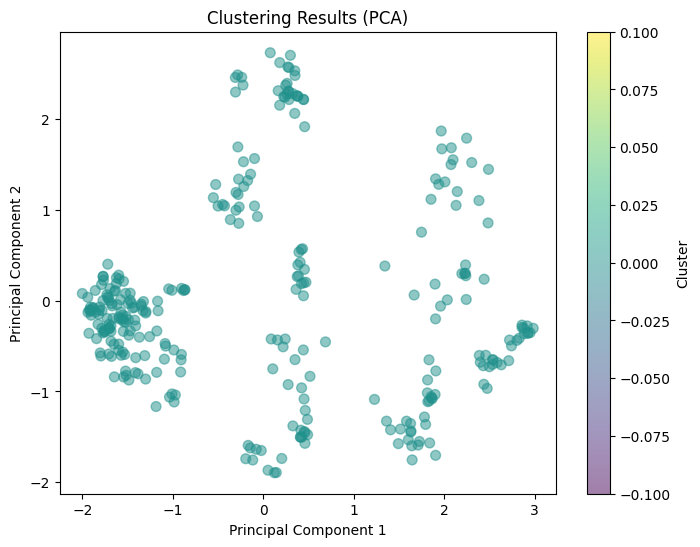

In [56]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='viridis', s=50, alpha=0.5)
plt.title('Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [58]:
# KMODES ALGO
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Initialize and fit the KModes model
km = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=1, random_state=42)
km.fit(X_imputed)

# Get cluster assignments from KModes
km_cluster_assignments = km.labels_

# Evaluate performance using various metrics
ari = adjusted_rand_score(cluster_assignments, km_cluster_assignments)
nmi = normalized_mutual_info_score(cluster_assignments, km_cluster_assignments)
fmi = fowlkes_mallows_score(cluster_assignments, km_cluster_assignments)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information Score (NMI):", nmi)
print("Folkes-Mallows Index (FMI):", fmi)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 47, cost: 2386.0
Run 1, iteration: 2/100, moves: 8, cost: 2386.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 113, cost: 2436.0
Run 2, iteration: 2/100, moves: 28, cost: 2395.0
Run 2, iteration: 3/100, moves: 3, cost: 2395.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 109, cost: 2406.0
Run 3, iteration: 2/100, moves: 25, cost: 2378.0
Run 3, iteration: 3/100, moves: 19, cost: 2355.0
Run 3, iteration: 4/100, moves: 7, cost: 2352.0
Run 3, iteration: 5/100, moves: 4, cost: 2348.0
Run 3, iteration: 6/100, moves: 0, cost: 2348.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 35, cost: 2349.0
Run 4, iteration: 2/100, moves: 18, cost: 2337.0
Run 4, iteration: 3/100, moves: 3, cost: 2337.

In [62]:
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Fit the K-Modes model
km = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=0, random_state=42)
km.fit(X_imputed)

# Get cluster assignments from K-Modes
km_cluster_assignments = km.labels_

# Flatten the true cluster assignments
y_flat = y.values.ravel()

# Evaluate performance of K-Modes
km_ari = adjusted_rand_score(y_flat, km_cluster_assignments)
km_nmi = normalized_mutual_info_score(y_flat, km_cluster_assignments)
km_fmi = fowlkes_mallows_score(y_flat, km_cluster_assignments)

# Evaluate performance of Stochastic Bernoulli Mixture model
sbm_ari = adjusted_rand_score(y_flat, cluster_assignments)
sbm_nmi = normalized_mutual_info_score(y_flat, cluster_assignments)
sbm_fmi = fowlkes_mallows_score(y_flat, cluster_assignments)


print("Performance Comparison:")
print("K-Modes - Adjusted Rand Index (ARI):", km_ari)
print("K-Modes - Normalized Mutual Information Score (NMI):", km_nmi)
print("K-Modes - Folkes-Mallows Index (FMI):", km_fmi)
print("----------------------------------------")
print("Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI):", sbm_ari)
print("Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI):", sbm_nmi)
print("Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI):", sbm_fmi)


Performance Comparison:
K-Modes - Adjusted Rand Index (ARI): 0.16608388765264684
K-Modes - Normalized Mutual Information Score (NMI): 0.4020358135575015
K-Modes - Folkes-Mallows Index (FMI): 0.37946365260388987
----------------------------------------
Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI): 0.0
Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI): 0.0
Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI): 0.2896598585640133


$\textbf{Report Intro}$
- Three assessment metrics were used to examine the performances of two clustering algorithms, K-Modes and Stochastic Bernoulli Mixture: Adjusted Rand Index (ARI), Normalized Mutual Information Score (NMI), and Folkes-Mallows Index (FMI). These measures shed light on how closely the clusters produced by the algorithms resemble the actual clustering assignments.

<br>

$\textbf{Performance Metrics:}$
1. K-Modes:
- Adjusted Rand Index (ARI): 0.166
- Normalized Mutual Information Score (NMI): 0.402
- Folkes-Mallows Index (FMI): 0.379

2. Stochastic Bernoulli Mixture:
- Adjusted Rand Index (ARI): 0.0
- Normalized Mutual Information Score (NMI): 0.0
- Folkes-Mallows Index (FMI): 0.290

<br>

$\textbf{Comparison and Analysis:}$
1. ARI
- For K-Modes, the ARI indicates a moderate level of similarity between the true cluster assignments and the clusters generated by the algorithm.
- In contrast, the ARI for Stochastic Bernoulli Mixture is 0.0, suggesting no agreement between the true and predicted clusters.
- The ARI measures the similarity of the clusterings, considering all pairs of samples and counting pairs that are assigned in the same or different clusters. A value close to 0 indicates random labeling.

2. NMI
- K-Modes achieves a relatively high NMI score, indicating a good level of mutual information between the true and predicted clusters.
- In contrast, Stochastic Bernoulli Mixture has an NMI of 0.0, suggesting no mutual information between the true and predicted clusters.
- NMI measures the mutual dependence between the true and predicted cluster assignments, normalized by entropy. A value of 0 indicates no mutual information.

3. FMI
- K-Modes has a lower FMI compared to its ARI and NMI scores, suggesting a weaker agreement between clusters based on the FMI metric.
- Stochastic Bernoulli Mixture also shows a lower FMI compared to its ARI and NMI, indicating a weaker agreement between clusters based on the FMI metric.
- FMI calculates the geometric mean of the pairwise precision and recall, providing a balanced measure of clustering performance. A higher FMI indicates better clustering performance.

<br>

$\textbf{Report Conclusion}$
- Based on all three evaluation metrics, K-Modes performance seems to be overall better than Stochastic Bernoulli Mixture. Poor performance is seen across all metrics as a result of Stochastic Bernoulli Mixture's inability to identify significant clusters in the dataset, even though K-Modes shows a moderate degree of agreement with the genuine clustering assignments. To enhance the Stochastic Bernoulli Mixture's clustering performance, more research and optimization might be needed.